In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles

In [2]:
dbFile = 'baseline_v1.4_10yrs.db'
conn = db.OpsimDatabase(dbFile)
outDir='temp'
resultsDb = db.ResultsDb(outDir=outDir)

In [3]:
bundleList = []
filtername = 'r'
nside = 64
sql = 'filter="%s"' % filtername
metric = metrics.NstarsMetric(filtername=filtername, crowding_error=0.1, metricName='Crowding_0.1')
slicer = slicers.HealpixSlicer(nside=nside)
summaryStats = [metrics.SumMetric()]
plotDict = {}
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict, summaryMetrics=summaryStats))

metric = metrics.NstarsMetric(filtername=filtername, crowding_error=0.2, metricName='Crowding_0.2')
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict, summaryMetrics=summaryStats))

metric = metrics.NstarsMetric(filtername=filtername, crowding_error=0.2, ignore_crowding=True, metricName='No_Crowding_0.2')
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict, summaryMetrics=summaryStats))

metric = metrics.NstarsMetric(filtername=filtername, crowding_error=0.1, ignore_crowding=True, metricName='No_Crowding_0.1')
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict, summaryMetrics=summaryStats))

bg = metricBundles.MetricBundleGroup(bundleList, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter="r" for columns ['fiveSigmaDepth', 'seeingFwhmGeom', 'fieldDec', 'fieldRA']
Found 474955 visits
Running:  ['opsim_Crowding_0_1_r_HEAL', 'opsim_Crowding_0_2_r_HEAL', 'opsim_No_Crowding_0_2_r_HEAL', 'opsim_No_Crowding_0_1_r_HEAL']


/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with "filter="r"" constraint now.
monopole: 19355.3  dipole: lon: -117.769, lat: -32.3481, amp: 24618.4


/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: UserWarning: Optimal bin calculation tried to make 259 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 40874.8  dipole: lon: -106.335, lat: -20.137, amp: 60766.4


/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: UserWarning: Optimal bin calculation tried to make 2137 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 57348.4  dipole: lon: -101.163, lat: -14.1797, amp: 94457.2


/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: UserWarning: Optimal bin calculation tried to make 1571 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 42489.1  dipole: lon: -101.777, lat: -15.8593, amp: 69329.8
Plotting complete.


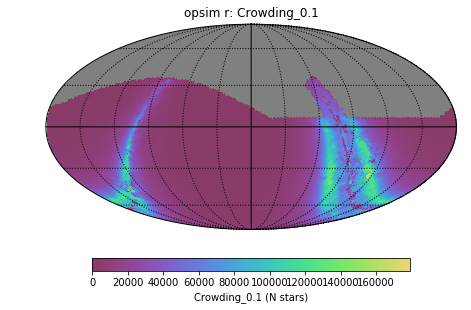

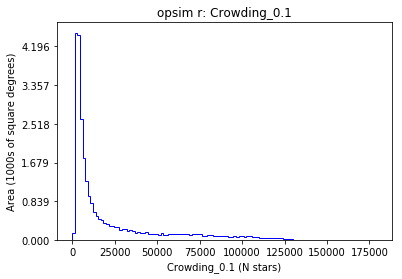

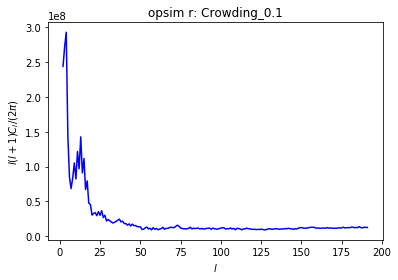

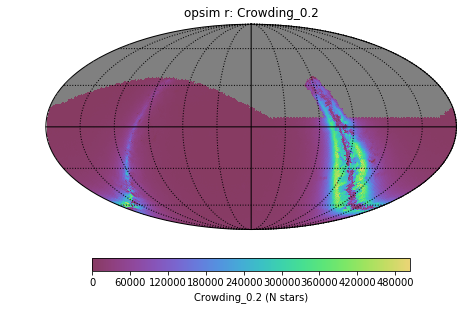

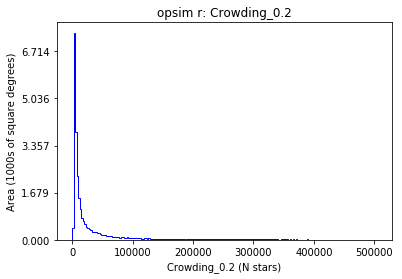

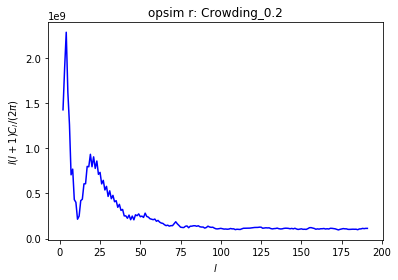

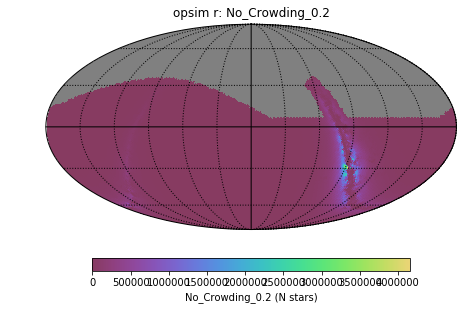

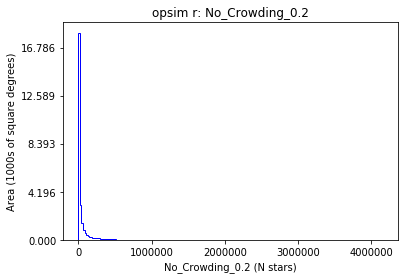

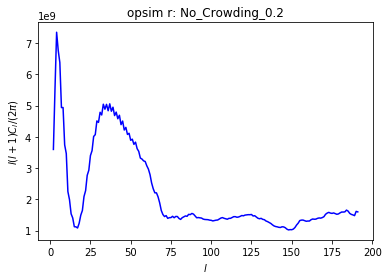

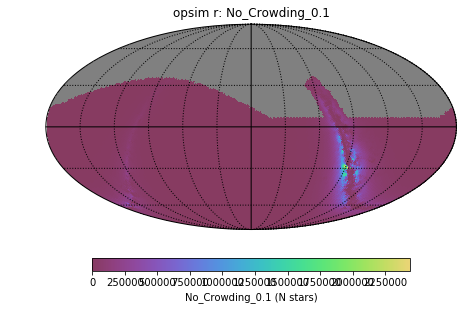

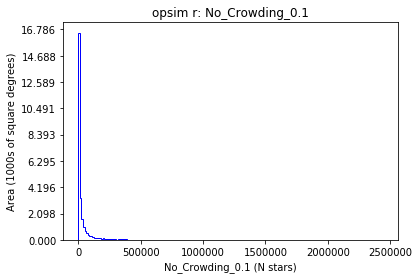

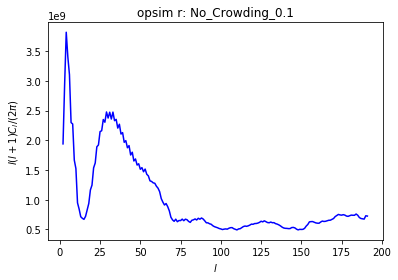

In [4]:
bg.plotAll(closefigs=False)

In [5]:
for b in bundleList:
    print(b.metric.name, b.summaryValues['Sum']/1e9)

Crowding_0.1 0.7219423401711571
Crowding_0.2 1.4139076578435157
No_Crowding_0.2 1.887332280981715
No_Crowding_0.1 1.420364278699568


In [6]:
## OK, let's double check by just making a coadded depth map and looking at the stellar density maps directly


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter="r" for columns ['fiveSigmaDepth', 'fieldDec', 'fieldRA']
Found 474955 visits
Running:  ['opsim_CoaddM5_r_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "filter="r"" constraint now.
monopole: 26.4889  dipole: lon: 114.971, lat: -69.4567, amp: 0.444189
Plotting complete.


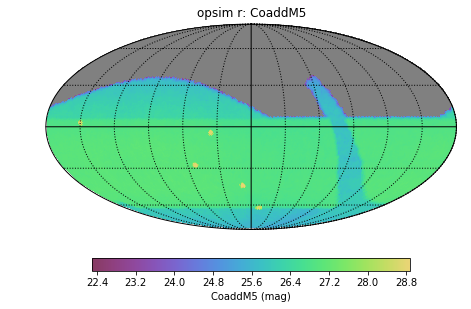

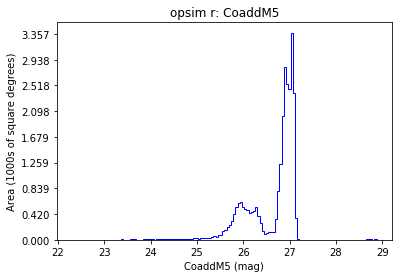

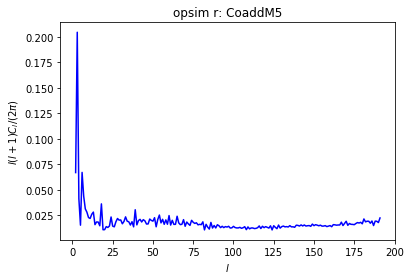

In [7]:
bundleList = []
filtername = 'r'

sql = 'filter="%s"' % filtername
metric = metrics.Coaddm5Metric()
slicer = slicers.HealpixSlicer(nside=nside)
summaryStats = [metrics.MedianMetric()]
plotDict = {}
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict, summaryMetrics=summaryStats))
bg = metricBundles.MetricBundleGroup(bundleList, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()
bg.plotAll(closefigs=False)

In [8]:
print(bundleList[0].summaryValues)

{'Median': 26.883260853309018}


In [9]:
data = np.load('/Users/yoachim/git_repos/sims_maps/StarMaps/starDensity_%s_nside_64.npz' % filtername)
# Cumulative number counts, units of stars/sq deg. Array at healpix locations
starDensity = data['starDensity'].copy()
# magnitude bins 
bins=data['bins'].copy()
# pixels where there were so many stars some were skipped
mask = data['overMaxMask']

In [10]:
bins

array([15. , 15.2, 15.4, 15.6, 15.8, 16. , 16.2, 16.4, 16.6, 16.8, 17. ,
       17.2, 17.4, 17.6, 17.8, 18. , 18.2, 18.4, 18.6, 18.8, 19. , 19.2,
       19.4, 19.6, 19.8, 20. , 20.2, 20.4, 20.6, 20.8, 21. , 21.2, 21.4,
       21.6, 21.8, 22. , 22.2, 22.4, 22.6, 22.8, 23. , 23.2, 23.4, 23.6,
       23.8, 24. , 24.2, 24.4, 24.6, 24.8, 25. , 25.2, 25.4, 25.6, 25.8,
       26. , 26.2, 26.4, 26.6, 26.8, 27. , 27.2, 27.4, 27.6, 27.8, 28. ])

/Users/yoachim/lsst/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


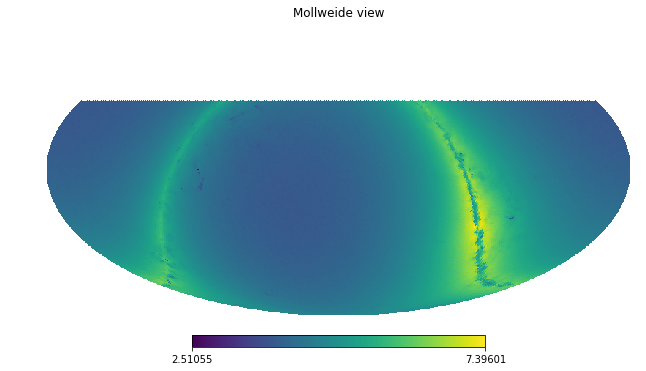

In [11]:
i=59
hp.mollview(np.log10(starDensity[:,i]))

In [12]:
# Full-ish sky
pix_area = hp.nside2pixarea(nside, degrees=True)
print(np.sum(starDensity[:,59])*pix_area/1e9, 'stars/1e9, down to r=', bins[i], )

7.349417353281459 stars/1e9, down to r= 26.799999999999958


In [13]:
# Let's check just WFD
out = np.where((bundleList[0].metricValues < 26.5) | (bundleList[0].metricValues.mask == True ))
temp_map = starDensity[:,i] +0
temp_map[out] = 0

/Users/yoachim/lsst/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


/Users/yoachim/lsst/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


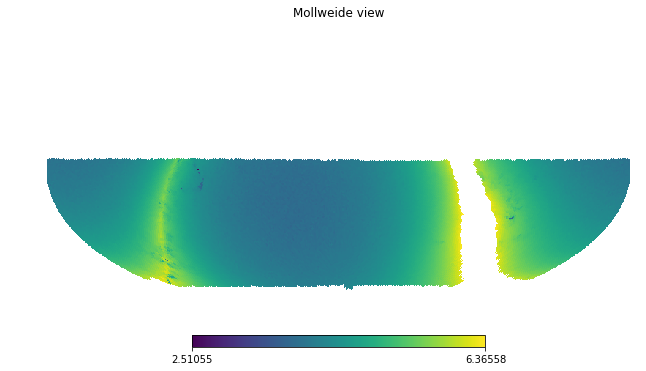

In [14]:
hp.mollview(np.log10(temp_map))

In [15]:
print('N stars/1e9 in WFD area, no crowding limits=', np.sum(temp_map*pix_area/1e9))
print('down to %s =' % filtername, bins[i])

N stars/1e9 in WFD area, no crowding limits= 2.0438085622323676
down to r = 26.799999999999958


In [16]:
# Looks like the science book said 4 billion stars with r <24.5 and 10 billion stars with r <27.8.
# Not clear if these are full-sky numbers or just WFD.
# The 10 billion seems high, but we're not getting down to 27.8. I get there would be 7 billion full-ish sky r < 28.